In [19]:
import pystan
import scipy
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

In [20]:
#### Preprocecing ###

In [21]:
Confirmed = pd.read_csv("../csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv")

In [22]:
df = Confirmed.groupby("Country/Region").sum()
df = df.drop(["Lat", "Long"], 1)
df = df.T
df = df.set_index(pd.to_datetime(df.index))
confirmed = df

In [23]:
contries = confirmed.max() >= 1000
confirmed = confirmed.loc[:, contries]
confirmed = confirmed.cummax()

In [24]:
df = pd.read_csv("../csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_recovered_global.csv")
df = df.groupby("Country/Region").sum()
df = df.drop(["Lat", "Long"], 1)
df = df.T
df = df.set_index(pd.to_datetime(df.index))
recovered = df.loc[:, contries]
recovered = recovered.cummax()


In [25]:
df = pd.read_csv("../csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv")
df = df.groupby("Country/Region").sum()
df = df.drop(["Lat", "Long"], 1)
df = df.T
df = df.set_index(pd.to_datetime(df.index))
death = df.loc[:, contries]
death = death.cummax()

In [30]:
### Data Preparation ###

In [146]:
country = 'Korea, South'
S0 = confirmed[country].values
R0 = recovered[country].values
D0 = death[country].values
P = 5000_0000
iter=2000

In [147]:
data = {'T': S0.shape[0], 'P': P, 'S0': S0, 'R0': R0, 'D0': D0}

In [33]:
### Model ###

In [43]:
sm = pystan.StanModel(file="turzin.stan")

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_101c6dab52da22ac0d9303c906e81fe1 NOW.


In [148]:
# Train the model and generate samples
fit = sm.sampling(data=data, iter=iter, init=0)

In [35]:
### Visualization functions ###

In [116]:
def sigmoid(x, theta, t0):
    return 1/(1 + np.exp(-theta*(x-t0)))

In [149]:
def simulate(init_inf, b0, b1, theta_b, b_date, q0, q1, theta_q, q_date, a, d, horizon):
    S = init_inf;
    R = 0;
    D = 0;
    S_list = [S]
    R_list = [R]
    D_list = [D]
    b_list = [b0]
    q_list = [q0]
    S0 = [q0 * S]
    R0 = [q0 * R]
    D0 = [D]
    for t in range(horizon):
        b = b0 + (b1-b0) * sigmoid(t, theta_b, b_date)
        I = (S - R - D) * b * (1 - S/P)
        q = q0 + (q1-q0) * sigmoid(t, theta_q, q_date)
        NR = a * (S - R - D)
        ND = d * (S - R - D)
        D = D + ND
        S = S + I
        R = R + NR
        S_list.append(S)
        R_list.append(R)
        D_list.append(D)
        b_list.append(b)
        q_list.append(q)
        S0.append(S0[-1]+q*I)
        R0.append(R0[-1]+a * (S0[-1] - R0[-1] - D0[-1]))
    data = pd.DataFrame({'S':np.array(S_list),
                        'R':np.array(R_list),
                        'D':np.array(D_list),
                        'b':np.array(b_list),
                        'q':np.array(q_list),
                        'S0':np.array(S0),
                        'R0':np.array(R0)},
                        index=pd.date_range(start=pd.to_datetime('2020-01-22'), periods=horizon+1, freq='D'))
    return data

In [153]:
def monte_carlo(fit, horizon):
    S = pd.DataFrame()
    R = pd.DataFrame()
    D = pd.DataFrame()
    b = pd.DataFrame()
    q = pd.DataFrame()
    S0 = pd.DataFrame()
    R0 = pd.DataFrame()
    I0 = pd.DataFrame()
    for i in range(fit['init_inf'].shape[0]):
        df = simulate(init_inf=fit['init_inf'][i],
                      b0=fit['b0'][i],
                      b1=fit['b1'][i],
                      theta_b=fit['theta_b'][i],
                      b_date=fit['b_date'][i],
                      q0=fit['q0'][i],
                      q1=fit['q1'][i],
                      theta_q=fit['theta_q'][i],
                      q_date=fit['q_date'][i],
                      a=fit['a'][i],
                      d=fit['d'][i],
                      horizon=horizon)
        S = pd.concat([S, df['S']], axis=1)
        R = pd.concat([R, df['R']], axis=1)
        D = pd.concat([D, df['D']], axis=1)
        b = pd.concat([b, df['b']], axis=1)
        q = pd.concat([q, df['q']], axis=1)
        S0 = pd.concat([S0, df['S0']], axis=1)
        R0 = pd.concat([R0, df['R0']], axis=1)
        I0 = pd.concat([I0, df['S0'] - df['R0']], axis=1)
    return S, R, D, b, q, S0, R0, I0
    

In [151]:
def extract_series(fit, name):
    value_list = []
    for d in range(S0.shape[0]):
        vals = fit['{}[{}]'.format(name, d+1)]
        value_list.append(vals)
    data = np.array(value_list)
    return pd.DataFrame(data, 
                        index=confirmed.index)

In [152]:
def draw(simulated, real=None):
    graph=pd.DataFrame()
    simulated = simulated.dropna(axis=1)
    median = simulated.median(axis=1)
    upper = simulated.quantile(q=0.75, axis=1)
    lower = simulated.quantile(q=0.25, axis=1)
    if not real is None:
        graph['Real'] = real
    graph['Median'] = median
    graph['Upper'] = upper
    graph['Lower'] = lower
    sns.relplot(kind="line", data=graph, aspect=2)

In [154]:
S, R, D, b, q, S0, R0, I0 = monte_carlo(fit, 120)

/Users/yoriyuki/.pyenv/versions/anaconda3-5.3.1/envs/COVID-19/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: overflow encountered in exp
  


In [155]:
S0.T.iloc[1].values

array([4.46191291e-02, 5.66633672e-02, 7.15723730e-02, 9.00275422e-02,
       1.12872343e-01, 1.41150866e-01, 1.76155543e-01, 2.19486213e-01,
       2.73123246e-01, 3.39518047e-01, 4.21705098e-01, 5.23440642e-01,
       6.49374355e-01, 8.05261852e-01, 9.98227735e-01, 1.23709120e+00,
       1.53276908e+00, 1.89877478e+00, 2.35183575e+00, 2.91265789e+00,
       3.60687153e+00, 4.46620223e+00, 5.52991937e+00, 6.84662823e+00,
       8.47648588e+00, 1.04939391e+01, 1.29911032e+01, 1.60819237e+01,
       1.99072831e+01, 2.46412332e+01, 3.04990751e+01, 1.59491783e+02,
       3.58322043e+02, 6.03930546e+02, 9.06900450e+02, 1.27976531e+03,
       1.73689799e+03, 2.29383017e+03, 2.96544397e+03, 3.76220899e+03,
       4.68366790e+03, 5.70956078e+03, 6.79240166e+03, 7.85978905e+03,
       8.83321647e+03, 9.65629254e+03, 1.03119854e+04, 1.08175008e+04,
       1.12063715e+04, 1.15128476e+04, 1.17644287e+04, 1.19805611e+04,
       1.21740302e+04, 1.23528905e+04, 1.25220923e+04, 1.26846366e+04,
      

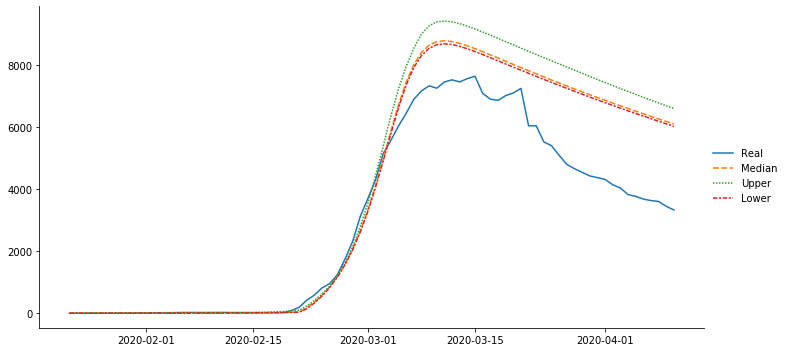

In [160]:
draw(I0, real=(confirmed-recovered)[country])

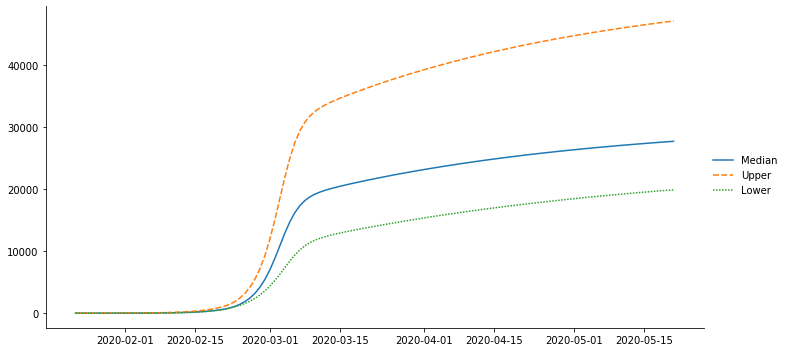

In [161]:
draw(S)

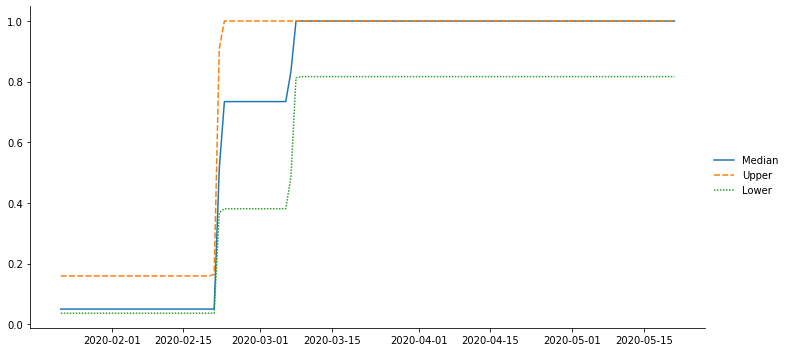

In [162]:
draw(q)

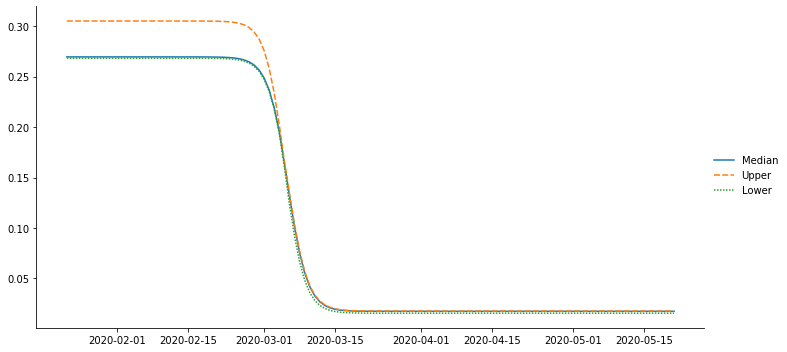

In [169]:
draw(b)

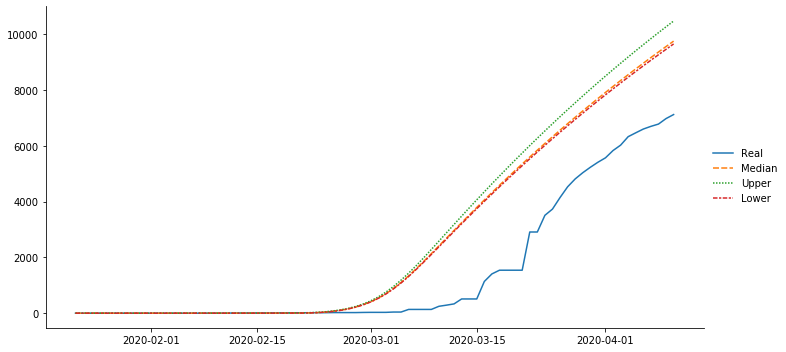

In [170]:
draw(R0, real=recovered[country])

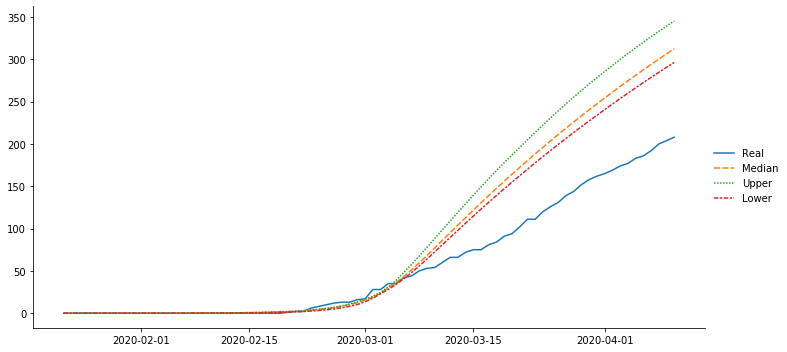

In [172]:
draw(D, real=death[country])

In [156]:
fit

Inference for Stan model: anon_model_101c6dab52da22ac0d9303c906e81fe1.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

                 mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
init_inf_alpha  4.8e7   3.4e7  5.0e7  74.83 3291.0  2.1e7 10.0e7  1.3e8      2   4.19
init_inf_beta   2.8e7   2.4e7  3.6e7  85.99  6.9e4  1.0e7  3.8e7  1.1e8      2   3.35
init_inf         1.47    0.99    1.4   0.04   0.41   1.01   2.55   3.99      2  17.29
b0_alpha       3326.7  4032.1 5851.5   1.84   2.28   39.8 5376.8  1.8e4      2   6.81
b0_beta        8276.9  9981.8  1.4e4   4.94   11.9  139.0  1.3e4  4.4e4      2   6.84
b0                0.3    0.04   0.06   0.26   0.27   0.27   0.34   0.41      2  38.58
b1_alpha        1.8e7   2.2e7  3.3e7   1.96   3.11  1.2e4  1.5e7  1.1e8      2   2.76
b1_beta         9.7e8   1.2e9  1.8e9  42.54  60.65  1.1e6  8.5e8  5.9e9      2   2.74
b1               0.02  2.2e-3 3.1e-3 

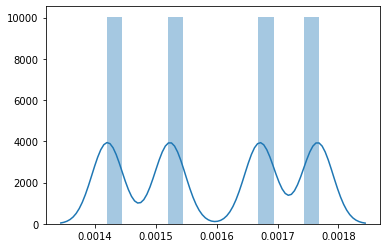

In [54]:
sns.distplot(fit['q0'])

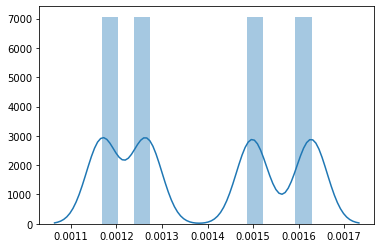

In [55]:
sns.distplot(fit['q1'])

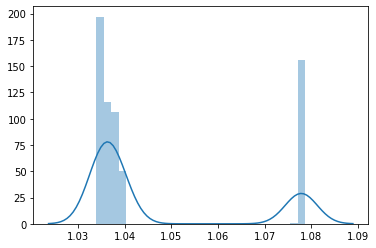

In [56]:
sns.distplot(fit['b0'])

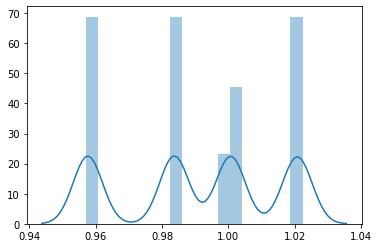

In [57]:
sns.distplot(fit['b1'])

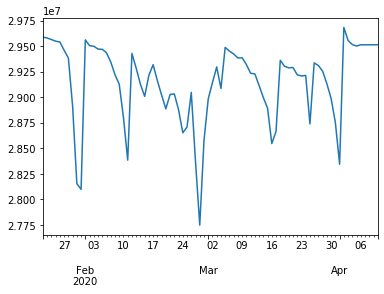

In [58]:
S[0].plot()

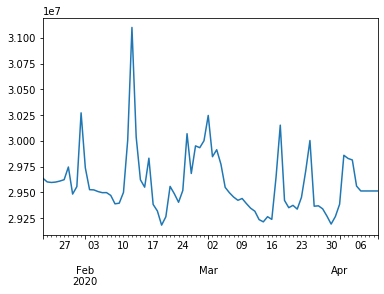

In [59]:
R[0].plot()

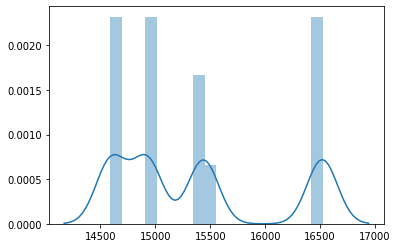

In [60]:
sns.distplot(fit['sigma_S0'])